# Logistic Regression Credit Risk Model Pipeline

1.  Logistic Regression Model

2.  Logistic Regression Model Performance:
-   **ROC_AUC**
-   **Balanced Accuracy** (Balanced Accuracy= 0.5 * (Sensitivity + Specificity))
-   **Confusion Matrix** (Precision Recall)
-   **Log Loss**

2.  Logistic Regression Model Calibration 
-   **Venn-Abers (cross and inductive)**
-   **Isotonic Regression**
-   **Platts Scaling**


3.  Logistic Regression Model Calibration Performance:
-   **Log Loss**
-   **Brier Score**
-   **Expected Calibration Error** (Plot for this as well)
-   **Calibration Curve**


Please also save predictions/probabilities, target (loan status) and ID for each set (we will need it the final step)
 

In [222]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    log_loss,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    brier_score_loss,

)

from matplotlib.gridspec import GridSpec


from venn_abers import VennAbersCalibrator
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import joblib



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns 

from sklearn.metrics import (
    roc_auc_score, balanced_accuracy_score, 
    confusion_matrix, precision_score, recall_score, log_loss, brier_score_loss, balanced_accuracy_score, f1_score
)

from sklearn.calibration import CalibratedClassifierCV, calibration_curve, CalibrationDisplay
from venn_abers import VennAbersCalibrator


import numpy as np
from sklearn.metrics import log_loss, brier_score_loss




# Helper Function

In [223]:
def model_metrics(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)

    metrics = {
        "ROC_AUC": round(roc_auc_score(y_true, y_prob), 3),
        "Balanced_Accuracy": round(balanced_accuracy_score(y_true, y_pred), 3),
        "Precision": round(precision_score(y_true, y_pred, zero_division=0), 3),
        "Recall": round(recall_score(y_true, y_pred, zero_division=0), 3),
        "F1": round(f1_score(y_true, y_pred, zero_division=0), 3),
        "LogLoss": round(log_loss(y_true, y_prob), 3),
    }

    return metrics




def expected_calibration_error_manual(y_true, y_proba, num_bins, split_strategy):
    """
    Compute ECE manually with support for 'uniform' and 'quantile' binning.
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels (0/1).
    y_proba : array-like
        Predicted probabilities.
    num_bins : int
        Number of bins to use.
    split_strategy : str
        'uniform' (equal-width bins) or 'quantile' (equal-frequency bins).
    """
    y_true = np.array(y_true)
    y_proba = np.array(y_proba)

    if split_strategy == "uniform":
        bins = np.linspace(0.0, 1.0, num_bins + 1)
    elif split_strategy == "quantile":
        bins = np.quantile(y_proba, np.linspace(0.0, 1.0, num_bins + 1))
    else:
        raise ValueError("split_strategy must be 'uniform' or 'quantile'")

    binids = np.digitize(y_proba, bins, right=True) - 1
    ece = 0.0

    for i in range(num_bins):
        mask = binids == i
        if np.sum(mask) > 0:
            bin_accuracy = np.mean(y_true[mask])
            bin_confidence = np.mean(y_proba[mask])
            ece += (np.sum(mask) / len(y_true)) * abs(bin_accuracy - bin_confidence)
    return ece

def calibration_metrics(y_true, y_proba, method_name):
    logloss = round(log_loss(y_true, y_proba), 3)
    brier = round(brier_score_loss(y_true, y_proba), 3)
    ece = round(expected_calibration_error_manual(np.array(y_true), np.array(y_proba)), 3)
    return {"Method": method_name, "Log Loss": logloss, "Brier Score": brier, "ECE": ece}


# Data Preparation for Modeling

In [ ]:
TRAIN_PATH = "DATA/preprocessed_train.csv"
VALID_PATH = "DATA/preprocessed_valid.csv"
TEST_PATH  = "DATA/preprocessed_test.csv"

In [ ]:
df_tr = pd.read_csv(TRAIN_PATH)
df_va = pd.read_csv(VALID_PATH)
df_te = pd.read_csv(TEST_PATH)

In [ ]:
TARGET = "loan_status"
ID_COL = "ID"

X_tr = df_tr.drop(columns=[TARGET, ID_COL])
y_tr = df_tr[TARGET]

X_va = df_va.drop(columns=[TARGET, ID_COL])
y_va = df_va[TARGET]  

X_te = df_te.drop(columns=[TARGET, ID_COL])
y_te = df_te[TARGET]

In [ ]:
feature_names = X_tr.columns.tolist() 

In [ ]:
# Scale features 
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_va = scaler.transform(X_va)
X_te  = scaler.transform(X_te)

In [ ]:
# Keep column names after scaling
X_tr = pd.DataFrame(scaler.fit_transform(X_tr), columns=feature_names)
X_va = pd.DataFrame(scaler.transform(X_va), columns=feature_names)
X_te = pd.DataFrame(scaler.transform(X_te), columns=feature_names)


In [ ]:
#to save the model
joblib.dump(scaler, "scaler.pkl")
#scaler = joblib.load("scaler.pkl")

['scaler.pkl']

In [ ]:
X_combined = np.vstack([X_tr, X_va])
y_combined = np.concatenate([y_tr, y_va])

# Logistic Model Training

In [ ]:
# Build logistic regression model
logistic_model = LogisticRegression(max_iter=1000, solver="lbfgs")

# Train
logistic_model.fit(X_tr, y_tr)

"""# Validate
y_pred_valid = logistic_model.predict(X_va)
print("\nValidation Accuracy:", round(accuracy_score(y_va, y_pred_valid),4))"""

# Test
y_pred_test = logistic_model.predict(X_te)

In [ ]:
joblib.dump(logistic_model, "LogisticRegression.pkl")

['LogisticRegression.pkl']

# Predictions

In [ ]:
proba_tr = logistic_model.predict_proba(X_tr)[:, 1]
proba_va = logistic_model.predict_proba(X_va)[:, 1]
proba_te = logistic_model.predict_proba(X_te)[:, 1] 

In [ ]:
print('Train Metrics:')
print(model_metrics(y_tr, proba_tr, threshold=0.5))

print('Validation Metrics:')
print(model_metrics(y_va, proba_va, threshold=0.5))

print('Test Metrics:')
print(model_metrics(y_te, proba_te, threshold=0.5))

Train Metrics:
{'ROC_AUC': 0.857, 'Balanced_Accuracy': 0.725, 'Precision': 0.736, 'Recall': 0.5, 'F1': 0.596, 'LogLoss': 0.359}
Validation Metrics:
{'ROC_AUC': 0.868, 'Balanced_Accuracy': 0.734, 'Precision': 0.73, 'Recall': 0.519, 'F1': 0.607, 'LogLoss': 0.345}
Test Metrics:
{'ROC_AUC': 0.858, 'Balanced_Accuracy': 0.715, 'Precision': 0.727, 'Recall': 0.481, 'F1': 0.579, 'LogLoss': 0.357}


# Feature Importance Plot

In [ ]:
# Get feature importance from logistic regression coefficients
feature_importances = (
    pd.DataFrame(
        logistic_model.coef_.ravel(),  # flatten coefficients
        columns=["Importance"],
        index=X_tr.columns
    )
    .reset_index(names="Features")
    .assign(Importance=lambda df: df["Importance"].abs())  # absolute importance
    .sort_values(by="Importance", ascending=False)
)

print(feature_importances)


                     Features  Importance
6         loan_percent_income    1.429881
4                  loan_grade    1.049947
5                   loan_amnt    0.662055
1       person_home_ownership    0.561478
3                 loan_intent    0.375495
0               person_income    0.175534
7   cb_person_default_on_file    0.067764
8  cb_person_cred_hist_length    0.020573
2           person_emp_length    0.004583


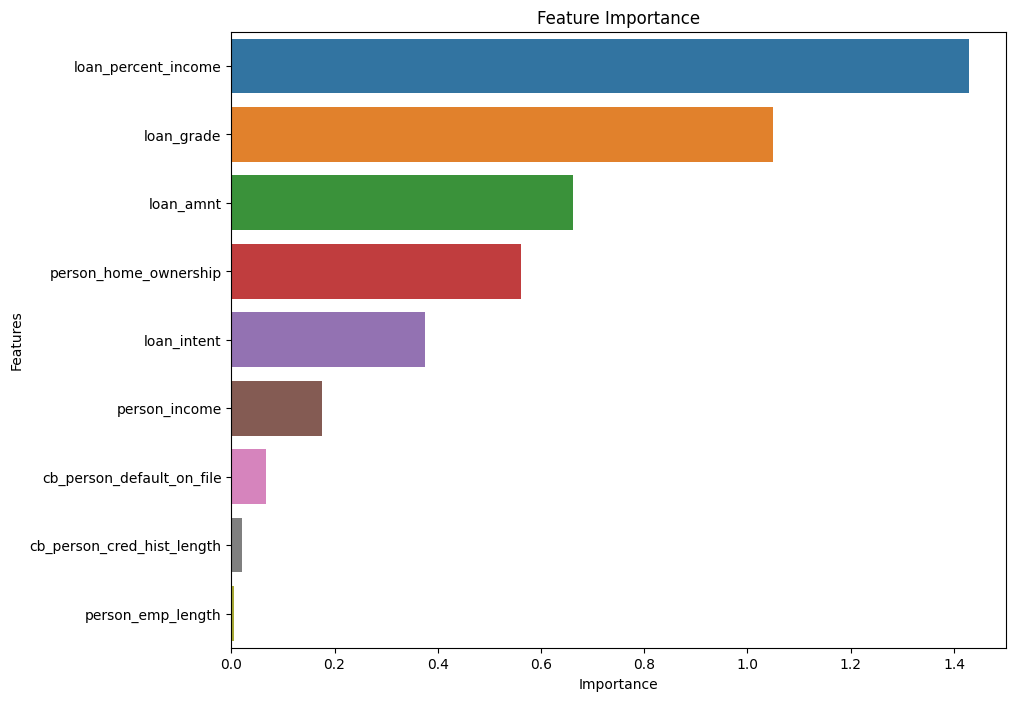

In [ ]:
# plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importances, x="Importance", y="Features")
plt.title("Feature Importance")
plt.show()

# Calibration

## Platt Calibration

In [ ]:
# --- 1) Prefit calibration models (validation set) ---
platt = CalibratedClassifierCV(estimator=logistic_model, method="sigmoid", cv="prefit")
platt.fit(X_va, y_va)

CalibratedClassifierCV(cv='prefit', estimator=LogisticRegression(max_iter=1000))

In [ ]:
#save the model 
joblib.dump(platt, "platt_calibrated_model.pkl")

['platt_calibrated_model.pkl']

In [ ]:
proba_tr_platt = platt.predict_proba(X_tr)[:, 1]
proba_va_platt = platt.predict_proba(X_va)[:, 1]
proba_te_platt = platt.predict_proba(X_te)[:, 1]

In [ ]:
print('Tra:', model_metrics(y_tr, proba_tr_platt, threshold=0.5))

print('Val:', model_metrics(y_va, proba_va_platt, threshold=0.5))

print('Tes:', model_metrics(y_te, proba_te_platt, threshold=0.5))

Tra: {'ROC_AUC': 0.857, 'Balanced_Accuracy': 0.724, 'Precision': 0.737, 'Recall': 0.499, 'F1': 0.595, 'LogLoss': 0.36}
Val: {'ROC_AUC': 0.868, 'Balanced_Accuracy': 0.734, 'Precision': 0.732, 'Recall': 0.519, 'F1': 0.608, 'LogLoss': 0.344}
Tes: {'ROC_AUC': 0.858, 'Balanced_Accuracy': 0.714, 'Precision': 0.726, 'Recall': 0.479, 'F1': 0.577, 'LogLoss': 0.357}


In [221]:
print('Tra', calibration_metrics(y_tr, proba_tr_platt, "Platt Scaling"))
print('Val', calibration_metrics(y_va, proba_va_platt, "Platt Scaling"))
print('Tes', calibration_metrics(y_te, proba_te_platt, "Platt Scaling"))

TypeError: expected_calibration_error_manual() missing 2 required positional arguments: 'num_bins' and 'split_strategy'

## Isotonic Calibration

In [ ]:
# --- ISOTONIC calibration fits calibration models on validation set (model already trained) ---
isotonic = CalibratedClassifierCV(estimator=logistic_model, method="isotonic", cv="prefit")
isotonic.fit(X_va, y_va)

CalibratedClassifierCV(cv='prefit', estimator=LogisticRegression(max_iter=1000),
                       method='isotonic')

In [ ]:
#save the model 
joblib.dump(isotonic, "isotonic_calibrated_model.pkl")

['isotonic_calibrated_model.pkl']

In [ ]:
proba_tr_iso = isotonic.predict_proba(X_tr)[:, 1]
proba_va_iso = isotonic.predict_proba(X_va)[:, 1]
proba_te_iso = isotonic.predict_proba(X_te)[:, 1]

In [ ]:
print('Tra:', model_metrics(y_tr, proba_tr_iso, threshold=0.5))

print('Val:', model_metrics(y_va, proba_va_iso, threshold=0.5))

print('Tes:', model_metrics(y_te, proba_te_iso, threshold=0.5))

Tra: {'ROC_AUC': 0.856, 'Balanced_Accuracy': 0.745, 'Precision': 0.695, 'Recall': 0.559, 'F1': 0.619, 'LogLoss': 0.367}
Val: {'ROC_AUC': 0.871, 'Balanced_Accuracy': 0.758, 'Precision': 0.703, 'Recall': 0.582, 'F1': 0.637, 'LogLoss': 0.337}
Tes: {'ROC_AUC': 0.857, 'Balanced_Accuracy': 0.742, 'Precision': 0.696, 'Recall': 0.552, 'F1': 0.616, 'LogLoss': 0.385}


In [ ]:
print('Tra:', calibration_metrics(y_tr, proba_tr_iso, "Isotonic Regression"))
print('Val:', calibration_metrics(y_va, proba_va_iso, "Isotonic Regression"))
print('Tes:', calibration_metrics(y_te, proba_te_iso, "Isotonic Regression"))

Tra: {'Method': 'Isotonic Regression', 'Log Loss': 0.367, 'Brier Score': 0.11, 'ECE': 0.017}
Val: {'Method': 'Isotonic Regression', 'Log Loss': 0.337, 'Brier Score': 0.104, 'ECE': 0.0}
Tes: {'Method': 'Isotonic Regression', 'Log Loss': 0.385, 'Brier Score': 0.109, 'ECE': 0.017}


## Venn-ABERS calibration

### Inductive

In [ ]:
p_train = logistic_model.predict_proba(X_tr)
p_cal = logistic_model.predict_proba(X_va)
p_test = logistic_model.predict_proba(X_te)

In [ ]:
VAC = VennAbersCalibrator()
proba_tr_iva, intervals_tr_iva = VAC.predict_proba(p_cal=p_cal, y_cal=y_va.values, p_test=p_train, p0_p1_output=True)
proba_val_iva, intervals_val_iva = VAC.predict_proba(p_cal=p_cal, y_cal=y_va.values, p_test=p_cal, p0_p1_output=True)
proba_te_iva, intervals_te_iva = VAC.predict_proba(p_cal=p_cal, y_cal=y_va.values, p_test=p_test, p0_p1_output=True)

In [ ]:
#save the model
joblib.dump(VAC, "VAC.pkl")

['VAC.pkl']

In [ ]:
proba_tr_iva = proba_tr_iva[:,1]
proba_val_iva = proba_val_iva[:,1]
proba_te_iva = proba_te_iva[:,1]

In [ ]:
print('Tra:', model_metrics(y_tr, proba_tr_iva, 0.5))
print('Val:', model_metrics(y_va, proba_val_iva, 0.5))
print('Tes:', model_metrics(y_te, proba_te_iva, 0.5))

Tra: {'ROC_AUC': 0.856, 'Balanced_Accuracy': 0.745, 'Precision': 0.695, 'Recall': 0.559, 'F1': 0.619, 'LogLoss': 0.359}
Val: {'ROC_AUC': 0.87, 'Balanced_Accuracy': 0.758, 'Precision': 0.703, 'Recall': 0.582, 'F1': 0.637, 'LogLoss': 0.339}
Tes: {'ROC_AUC': 0.857, 'Balanced_Accuracy': 0.742, 'Precision': 0.695, 'Recall': 0.551, 'F1': 0.615, 'LogLoss': 0.356}


In [ ]:
print('Tra:', calibration_metrics(y_tr, proba_tr_iva, "Inductive Venn-ABERS"))
print('Val:', calibration_metrics(y_va, proba_val_iva, "Inductive Venn-ABERS"))
print('Tes:', calibration_metrics(y_te, proba_te_iva, "Inductive Venn-ABERS"))

Tra: {'Method': 'Inductive Venn-ABERS', 'Log Loss': 0.359, 'Brier Score': 0.11, 'ECE': 0.016}
Val: {'Method': 'Inductive Venn-ABERS', 'Log Loss': 0.339, 'Brier Score': 0.104, 'ECE': 0.005}
Tes: {'Method': 'Inductive Venn-ABERS', 'Log Loss': 0.356, 'Brier Score': 0.109, 'ECE': 0.016}


### Cross Venn-ABERS

In [ ]:
# combine training and validation for cross Venn-ABERS

X_cvap = pd.concat([X_tr, X_va], axis=0, ignore_index=True)
y_cvap = pd.concat([y_tr, y_va], axis=0, ignore_index=True)

In [ ]:
model=LogisticRegression(max_iter=100, solver="lbfgs")

In [ ]:
va_cross = VennAbersCalibrator(
    estimator=model, 
    inductive=False,
    n_splits=5,          
    random_state=42
)

In [ ]:
va_cross.fit(X_cvap, y_cvap) #combine train and valid 

In [ ]:
#save the model
joblib.dump(va_cross, "va_cross_calibrator.pkl")

['va_cross_calibrator.pkl']

In [ ]:
#save the model
joblib.dump(model, "LogisticRegression1.pkl")

['LogisticRegression1.pkl']

In [ ]:
proba_train_cva, intervals_tr_cva = va_cross.predict_proba(X_tr, p0_p1_output=True)
proba_val_cva, intervals_val_cva = va_cross.predict_proba(X_va, p0_p1_output=True)
proba_test_cva, intervals_te_cva = va_cross.predict_proba(X_te, p0_p1_output=True)

In [ ]:
proba_tr_cva = proba_train_cva[:,1]
proba_val_cva = proba_val_cva[:,1]
proba_te_cva = proba_test_cva[:,1]

In [ ]:
# print model performance
print('Tra:', model_metrics(y_tr, proba_tr_cva, 0.5))
print('Val:', model_metrics(y_va, proba_val_cva, 0.5))
print('Test:', model_metrics(y_te, proba_te_cva, 0.5))  

Tra: {'ROC_AUC': 0.857, 'Balanced_Accuracy': 0.728, 'Precision': 0.733, 'Recall': 0.51, 'F1': 0.601, 'LogLoss': 0.357}
Val: {'ROC_AUC': 0.868, 'Balanced_Accuracy': 0.74, 'Precision': 0.729, 'Recall': 0.533, 'F1': 0.616, 'LogLoss': 0.343}
Test: {'ROC_AUC': 0.859, 'Balanced_Accuracy': 0.719, 'Precision': 0.722, 'Recall': 0.49, 'F1': 0.584, 'LogLoss': 0.354}


In [ ]:
# print calibration performance
print('Tra:', calibration_metrics(y_tr, proba_tr_cva, "Cross Venn-ABERS"))
print('Val:', calibration_metrics(y_va, proba_val_cva, "Cross Venn-ABERS"))
print('Test:', calibration_metrics(y_te, proba_te_cva, "Cross Venn-ABERS"))

Tra: {'Method': 'Cross Venn-ABERS', 'Log Loss': 0.357, 'Brier Score': 0.11, 'ECE': 0.004}
Val: {'Method': 'Cross Venn-ABERS', 'Log Loss': 0.343, 'Brier Score': 0.105, 'ECE': 0.016}
Test: {'Method': 'Cross Venn-ABERS', 'Log Loss': 0.354, 'Brier Score': 0.108, 'ECE': 0.009}


# Save predictions

In [ ]:
# Compute mean/min/max for p0/p1 of CROSS VA for test
p0s_test = intervals_te_cva[0][:, :5]
p1s_test = intervals_te_cva[0][:, 5:]

mean_p0_test = np.mean(p0s_test, axis=1)
mean_p1_test = np.mean(p1s_test, axis=1)
min_p0_test = np.min(p0s_test, axis=1)
max_p1_test = np.max(p1s_test, axis=1)

# Compute mean/min/max for p0/p1 of CROSS VA for validation
p0s_val = intervals_val_cva[0][:, :5]
p1s_val = intervals_val_cva[0][:, 5:]

mean_p0_val = np.mean(p0s_val, axis=1)
mean_p1_val = np.mean(p1s_val, axis=1)
min_p0_val = np.min(p0s_val, axis=1)
max_p1_val = np.max(p1s_val, axis=1)

# Compute mean/min/max for p0/p1 of CROSS VA for train
p0s_train = intervals_tr_cva[0][:, :5]
p1s_train = intervals_tr_cva[0][:, 5:]

mean_p0_train = np.mean(p0s_train, axis=1)
mean_p1_train = np.mean(p1s_train, axis=1)
min_p0_train = np.min(p0s_train, axis=1)
max_p1_train = np.max(p1s_train, axis=1)

In [ ]:
prob_tr = pd.DataFrame({
    "ID": df_tr[ID_COL],
    "Raw (Uncalibrated)": proba_tr,
    "Platt Scaling": proba_tr_platt,
    "Isotonic Regression": proba_tr_iso,
    "Venn-Abers (IVAP)": proba_tr_iva,
    "P0 (IVAP)": intervals_tr_iva[:,0],
    "P1 (IVAP)": intervals_tr_iva[:,1],
    "Venn-Abers (CVAP)": proba_tr_cva,
    "Mean P0 (CVAP)": mean_p0_train,
    "Mean P1 (CVAP)": mean_p1_train,
    "Min P0 (CVAP)": min_p0_train,
    "Max P1 (CVAP)": max_p1_train,
    "loan_status": y_tr
})

prob_val = pd.DataFrame({
    "ID": df_va[ID_COL],
    "Raw (Uncalibrated)": proba_va,
    "Platt Scaling": proba_va_platt,
    "Isotonic Regression": proba_va_iso,
    "Venn-Abers (IVAP)": proba_val_iva,
    "P0 (IVAP)": intervals_val_iva[:,0],
    "P1 (IVAP)": intervals_val_iva[:,1],
    "Venn-Abers (CVAP)": proba_val_cva,
    "Mean P0 (CVAP)": mean_p0_val,
    "Mean P1 (CVAP)": mean_p1_val,
    "Min P0 (CVAP)": min_p0_val,
    "Max P1 (CVAP)": max_p1_val,
    "loan_status": y_va
})

prob_test = pd.DataFrame({
    "ID": df_te[ID_COL],
    "Raw (Uncalibrated)": proba_te,
    "Platt Scaling": proba_te_platt,
    "Isotonic Regression": proba_te_iso,
    "Venn-Abers (IVAP)": proba_te_iva,
    "P0 (IVAP)": intervals_te_iva[:,0],
    "P1 (IVAP)": intervals_te_iva[:,1],
    "Venn-Abers (CVAP)": proba_te_cva,
    "Mean P0 (CVAP)": mean_p0_test,
    "Mean P1 (CVAP)": mean_p1_test,
    "Min P0 (CVAP)": min_p0_test,
    "Max P1 (CVAP)": max_p1_test,
    "loan_status": y_te
})

In [ ]:
prob_tr.head()

,ID,Raw (Uncalibrated),Platt Scaling,Isotonic Regression,Venn-Abers (IVAP),P0 (IVAP),P1 (IVAP),Venn-Abers (CVAP),Mean P0 (CVAP),Mean P1 (CVAP),Min P0 (CVAP),Max P1 (CVAP),loan_status
0,23482,0.252481,0.241552,0.208617,0.209932,0.208145,0.210407,0.233656,0.230792,0.235026,0.207483,0.252336,0
1,14094,0.405022,0.399316,0.392523,0.394495,0.388889,0.398148,0.401264,0.398594,0.403780,0.356495,0.459302,1
2,3966,0.054368,0.047274,0.053455,0.054616,0.053381,0.054688,0.067185,0.062922,0.067780,0.054161,0.080000,0
3,5052,0.018821,0.015429,0.023121,0.028217,0.022989,0.028369,0.025502,0.022674,0.026367,0.019093,0.040323,0
4,25312,0.492868,0.491386,0.526316,0.525926,0.522388,0.529851,0.503068,0.494503,0.511819,0.460674,0.540541,0


In [ ]:
prob_val.head()

,ID,Raw (Uncalibrated),Platt Scaling,Isotonic Regression,Venn-Abers (IVAP),P0 (IVAP),P1 (IVAP),Venn-Abers (CVAP),Mean P0 (CVAP),Mean P1 (CVAP),Min P0 (CVAP),Max P1 (CVAP),loan_status
0,8881,0.311375,0.301981,0.208617,0.209932,0.208145,0.210407,0.263093,0.255940,0.267669,0.209756,0.307692,1
1,22262,0.505493,0.504642,0.570552,0.553944,0.538462,0.573171,0.515562,0.508637,0.522650,0.466667,0.563830,0
2,10162,0.574157,0.576707,0.588235,0.584906,0.576923,0.596154,0.570305,0.566196,0.575380,0.520231,0.606061,0
3,32333,0.079166,0.070377,0.065517,0.068493,0.065292,0.068729,0.080581,0.078203,0.081006,0.067416,0.085282,0
4,14369,0.008729,0.006872,0.000000,0.012500,0.000000,0.012658,0.013917,0.001695,0.014661,0.000000,0.020408,0


In [ ]:
prob_test.head()

,ID,Raw (Uncalibrated),Platt Scaling,Isotonic Regression,Venn-Abers (IVAP),P0 (IVAP),P1 (IVAP),Venn-Abers (CVAP),Mean P0 (CVAP),Mean P1 (CVAP),Min P0 (CVAP),Max P1 (CVAP),loan_status
0,20441,0.020382,0.016780,0.023121,0.028217,0.022989,0.028369,0.026823,0.022674,0.027643,0.019093,0.040404,0
1,1091,0.874018,0.883839,0.939394,0.925440,0.924242,0.940299,0.899312,0.895338,0.927925,0.882353,0.959184,1
2,4763,0.273264,0.262787,0.208617,0.209932,0.208145,0.210407,0.236197,0.230792,0.238575,0.207483,0.259259,0
3,12382,0.609563,0.613783,0.672986,0.671362,0.669811,0.674528,0.600001,0.594997,0.607582,0.585859,0.631579,0
4,15113,0.011773,0.009414,0.016393,0.022495,0.016129,0.022642,0.020845,0.011994,0.021424,0.007463,0.027211,0


In [ ]:
prob_tr.shape, prob_val.shape, prob_test.shape

((20745, 13), (5187, 13), (6484, 13))

In [ ]:
X_tr.shape, X_va.shape, X_te.shape

((20745, 9), (5187, 9), (6484, 9))

In [ ]:
prob_tr.to_csv('prob_tr_logistic.csv', index=False)
prob_val.to_csv('prob_val_logistic.csv', index=False)
prob_test.to_csv('prob_test_logistic.csv', index=False)

# Comparison of Calibrations


Calibration Performance (Test Set):


,Log Loss,Brier Score,ECE
Method,,,
Raw (Uncalibrated),0.357,0.109,0.024
Platt Scaling,0.357,0.109,0.024
Isotonic Regression,0.385,0.109,0.017
Venn-Abers (IVAP),0.356,0.109,0.016
Venn-Abers (CVAP),0.354,0.108,0.009


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument

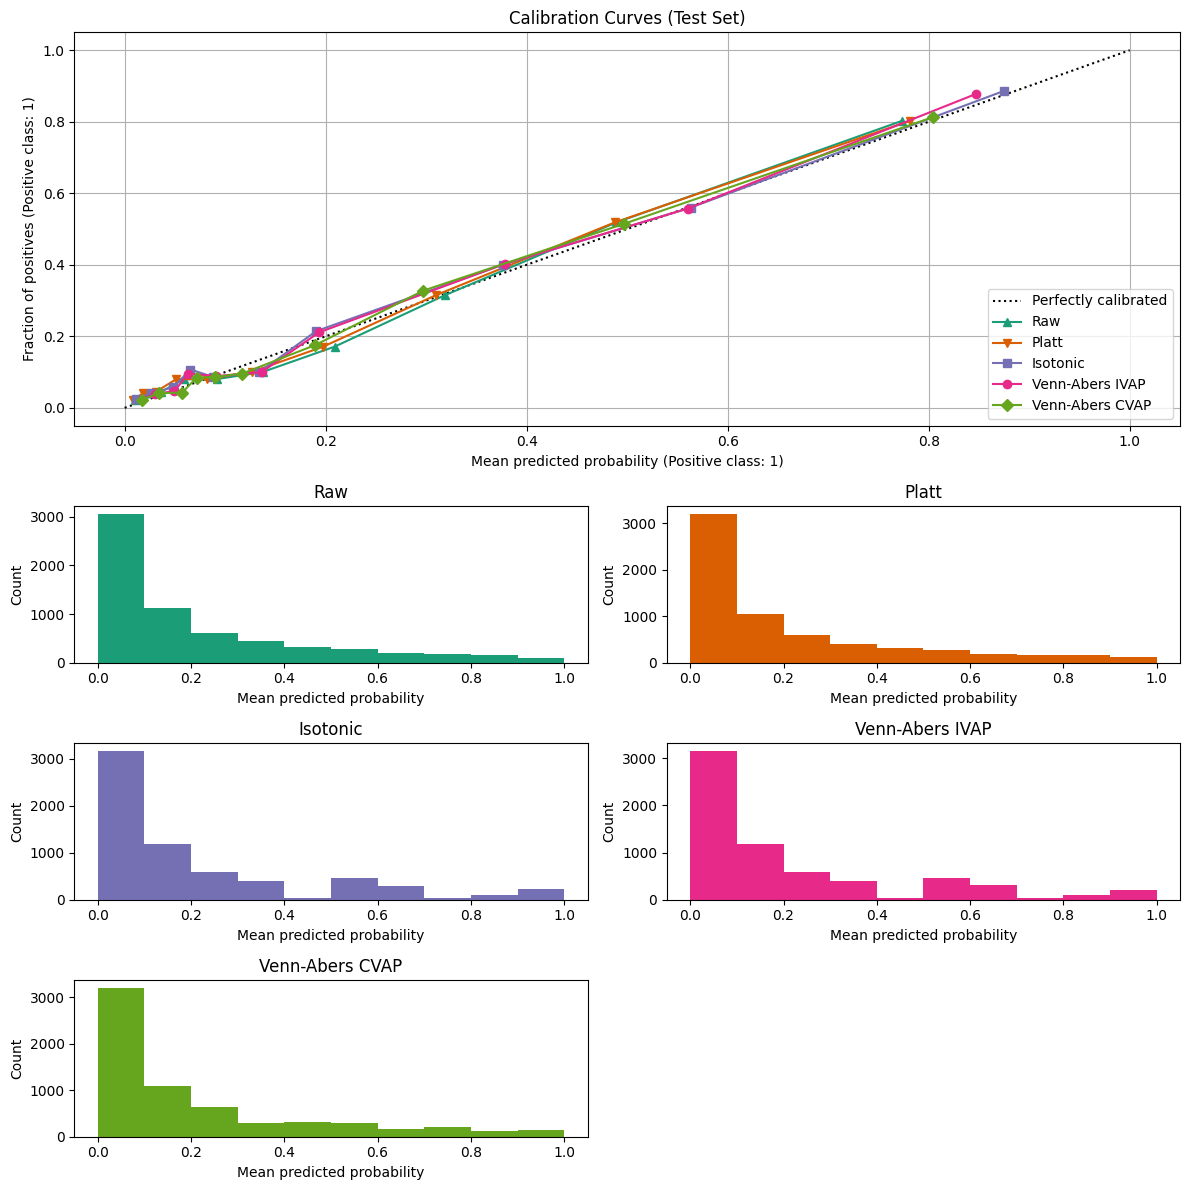

In [ ]:
#######################################################################################
############################# Test Set ################################################
#######################################################################################

results = []
results.append(calibration_metrics(y_te, proba_te,      "Raw (Uncalibrated)"))
results.append(calibration_metrics(y_te, proba_te_platt,    "Platt Scaling"))
results.append(calibration_metrics(y_te, proba_te_iso,      "Isotonic Regression"))
results.append(calibration_metrics(y_te, proba_te_iva,       "Venn-Abers (IVAP)"))
results.append(calibration_metrics(y_te, proba_te_cva,     "Venn-Abers (CVAP)"))

calib_df = pd.DataFrame(results).set_index("Method").round(4)
print("\nCalibration Performance (Test Set):")
display(calib_df)



pred_list = [
    (proba_te, "Raw"),
    (proba_te_platt, "Platt"),
    (proba_te_iso, "Isotonic"),
    (proba_te_iva, "Venn-Abers IVAP"),
    (proba_te_cva, "Venn-Abers CVAP"),
]

# --- Start of Changes ---

fig = plt.figure(figsize=(12, 12)) # Increased height slightly for better layout
# GridSpec to 5 rows to make space for the 5th histogram
gs = GridSpec(5, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o", "D"]
for i, (pred, name) in enumerate(pred_list):
    show = CalibrationDisplay.from_predictions(
        y_te,
        pred,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
        strategy="quantile"
    )
    calibration_displays[name] = show

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Curves (Test Set)")

# 2. Added the 5th coordinate for the "Venn-Abers CVAP" plot
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0)]

# --- End of Changes ---

for i, (_, name) in enumerate(pred_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()


Calibration Performance (Validation Set):


,Log Loss,Brier Score,ECE
Method,,,
Raw (Uncalibrated),0.345,0.106,0.016
Platt Scaling,0.344,0.105,0.014
Isotonic Regression,0.337,0.104,0.000
Venn-Abers (IVAP),0.339,0.104,0.005
Venn-Abers (CVAP),0.343,0.105,0.016


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument

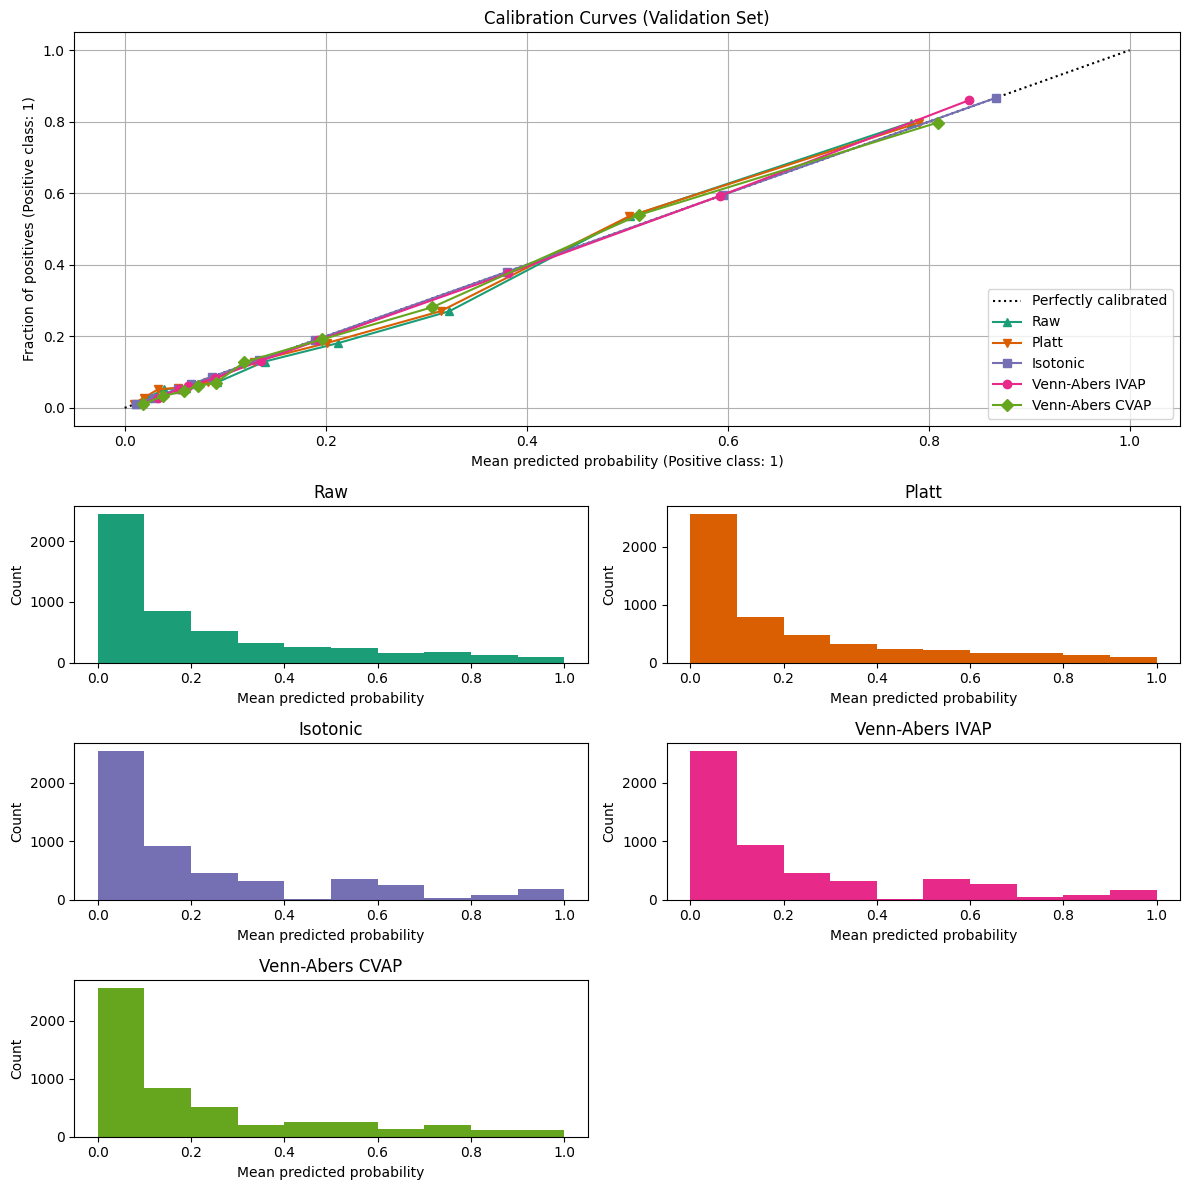

In [ ]:
#######################################################################################
############################# Validation Set ################################################
#######################################################################################

results = []
results.append(calibration_metrics(y_va, proba_va,      "Raw (Uncalibrated)"))
results.append(calibration_metrics(y_va, proba_va_platt,    "Platt Scaling"))
results.append(calibration_metrics(y_va, proba_va_iso,      "Isotonic Regression"))
results.append(calibration_metrics(y_va, proba_val_iva,       "Venn-Abers (IVAP)"))
results.append(calibration_metrics(y_va, proba_val_cva,     "Venn-Abers (CVAP)"))

calib_df = pd.DataFrame(results).set_index("Method").round(4)
print("\nCalibration Performance (Validation Set):")
display(calib_df)



pred_list = [
    (proba_va, "Raw"),
    (proba_va_platt, "Platt"),
    (proba_va_iso, "Isotonic"),
    (proba_val_iva, "Venn-Abers IVAP"),
    (proba_val_cva, "Venn-Abers CVAP"),
]

# --- Start of Changes ---

fig = plt.figure(figsize=(12, 12)) # Increased height slightly for better layout
# GridSpec to 5 rows to make space for the 5th histogram
gs = GridSpec(5, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o", "D"]
for i, (pred, name) in enumerate(pred_list):
    show = CalibrationDisplay.from_predictions(
        y_va,
        pred,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
        strategy='quantile'
    )
    calibration_displays[name] = show

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Curves (Validation Set)")

# 2. Added the 5th coordinate for the "Venn-Abers CVAP" plot
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0)]

# --- End of Changes ---

for i, (_, name) in enumerate(pred_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [ ]:
prob_test['raw_bin'] = pd.qcut(prob_test['Raw (Uncalibrated)'], q=10, labels=False, duplicates='drop')
prob_test['iso_bin'] = pd.qcut(prob_test['Isotonic Regression'], q=10, labels=False, duplicates='drop')
prob_test['platt_bin'] = pd.qcut(prob_test['Platt Scaling'], q=10, labels=False, duplicates='drop')
prob_test['ivap_bin'] = pd.qcut(prob_test['Venn-Abers (IVAP)'], q=10, labels=False, duplicates='drop')
prob_test['cvap_bin'] = pd.qcut(prob_test['Venn-Abers (CVAP)'], q=10, labels=False, duplicates='drop')


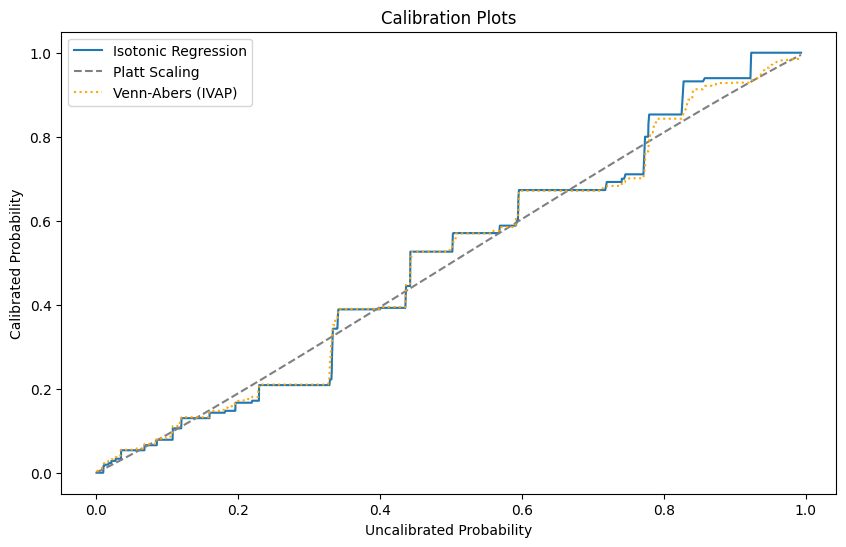

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(prob_test.sort_values('Raw (Uncalibrated)')['Raw (Uncalibrated)'], prob_test.sort_values('Raw (Uncalibrated)')['Isotonic Regression'], label='Isotonic Regression')
plt.plot(prob_test.sort_values('Raw (Uncalibrated)')['Raw (Uncalibrated)'], prob_test.sort_values('Raw (Uncalibrated)')['Platt Scaling'], linestyle='--', color='gray', label='Platt Scaling')
plt.plot(prob_test.sort_values('Raw (Uncalibrated)')['Raw (Uncalibrated)'], prob_test.sort_values('Raw (Uncalibrated)')['Venn-Abers (IVAP)'], linestyle=':', color='orange', label='Venn-Abers (IVAP)')
# plt.plot(prob_test.sort_values('Raw (Uncalibrated)')['Raw (Uncalibrated)'], prob_test.sort_values('Raw (Uncalibrated)')['Venn-Abers (CVAP)'], linestyle='-.', color='purple', label='Venn-Abers (CVAP)')
plt.xlabel('Uncalibrated Probability')
plt.ylabel('Calibrated Probability')
plt.title('Calibration Plots')
plt.legend()
plt.show()

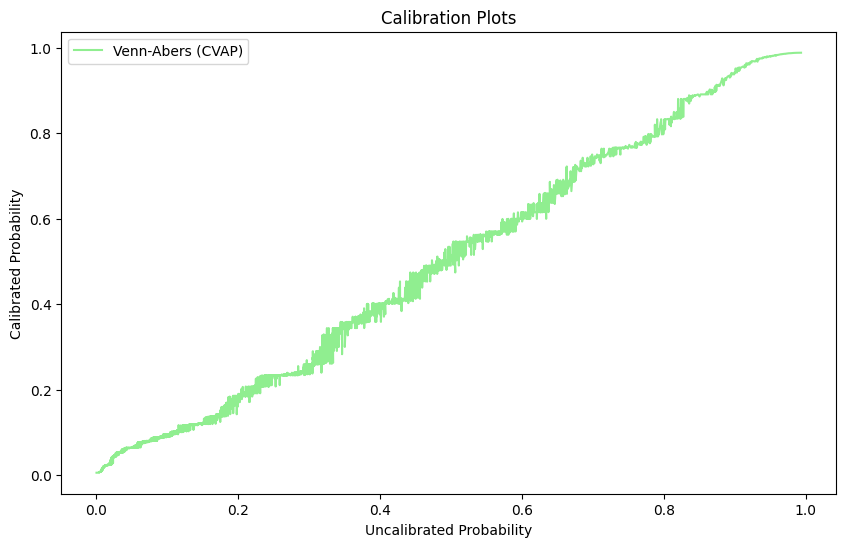

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(prob_test.sort_values('Raw (Uncalibrated)')['Raw (Uncalibrated)'], prob_test.sort_values('Raw (Uncalibrated)')['Venn-Abers (CVAP)'],color='lightgreen', label='Venn-Abers (CVAP)')
plt.xlabel('Uncalibrated Probability')
plt.ylabel('Calibrated Probability')
plt.title('Calibration Plots')
plt.legend()
plt.show()

In [ ]:
test_rates = prob_test.groupby('raw_bin')[['Raw (Uncalibrated)', 'Platt Scaling', 'Isotonic Regression', 'Venn-Abers (IVAP)', 'Venn-Abers (CVAP)', 'loan_status']].mean().reset_index()


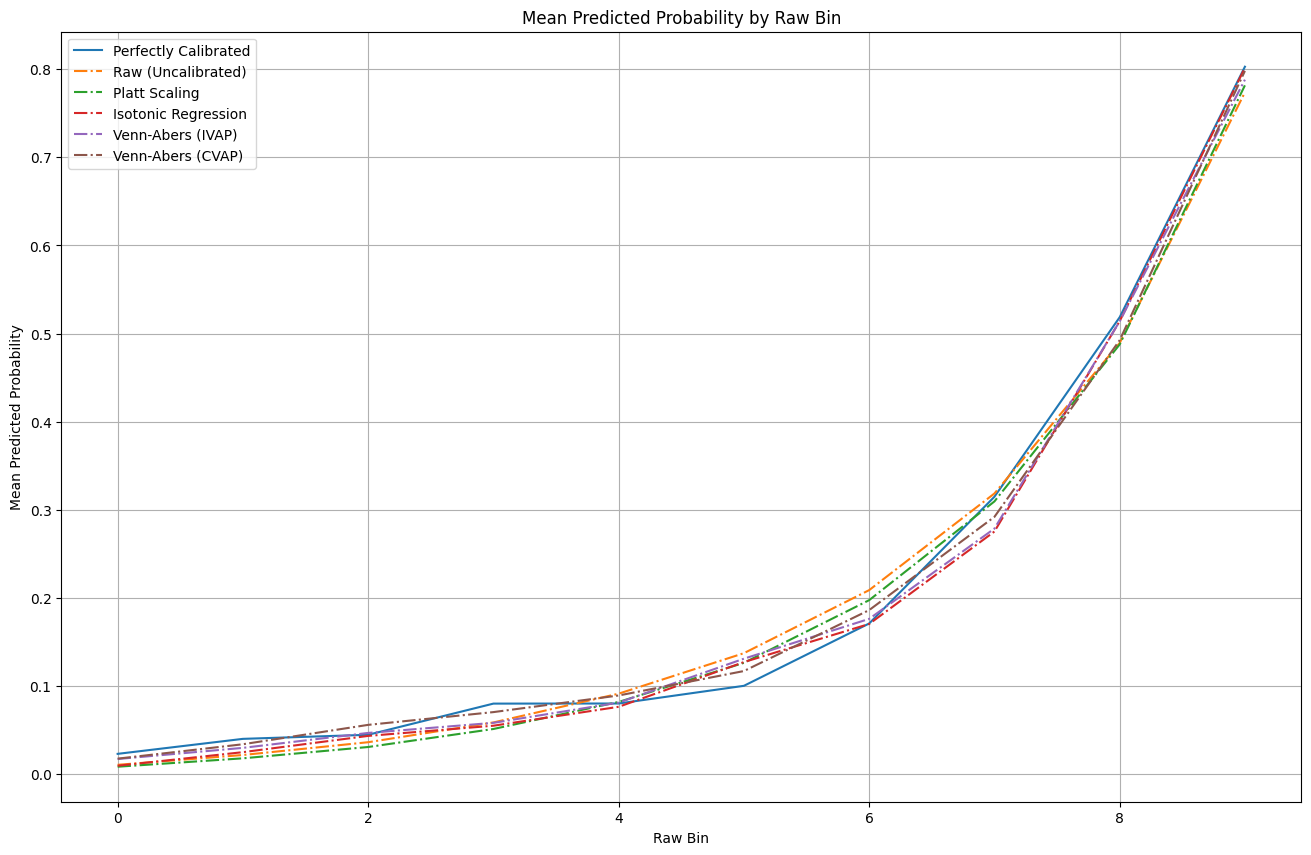

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(test_rates['raw_bin'], test_rates['loan_status'], linestyle='-', label='Perfectly Calibrated')
plt.plot(test_rates['raw_bin'], test_rates['Raw (Uncalibrated)'], linestyle='dashdot',  label='Raw (Uncalibrated)')
plt.plot(test_rates['raw_bin'], test_rates['Platt Scaling'], linestyle='dashdot',  label='Platt Scaling')
plt.plot(test_rates['raw_bin'], test_rates['Isotonic Regression'], linestyle='dashdot', label='Isotonic Regression')
plt.plot(test_rates['raw_bin'], test_rates['Venn-Abers (IVAP)'], linestyle='dashdot', label='Venn-Abers (IVAP)')
plt.plot(test_rates['raw_bin'], test_rates['Venn-Abers (CVAP)'], linestyle='dashdot', label='Venn-Abers (CVAP)')
plt.xlabel('Raw Bin')
plt.ylabel('Mean Predicted Probability')
plt.title('Mean Predicted Probability by Raw Bin')
plt.legend()
plt.grid()
plt.show()

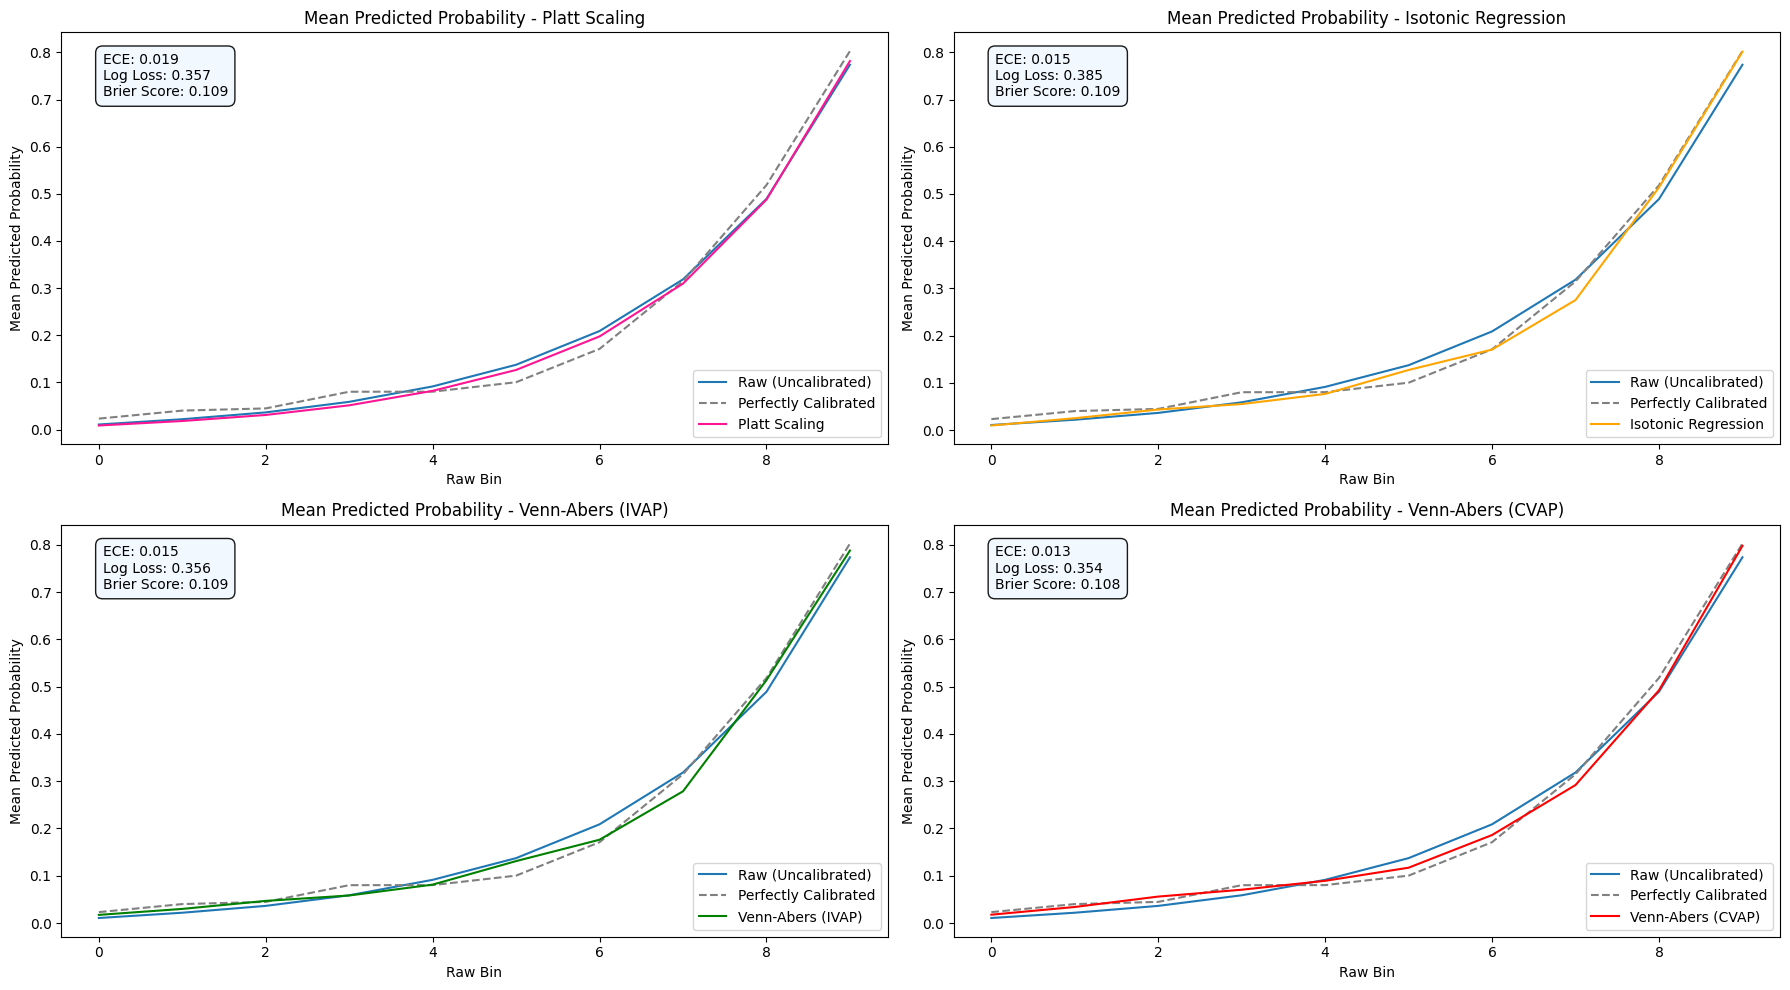

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))
axs = axs.flatten()
colors = ['deeppink', 'orange', 'green', 'red']

for i, col in enumerate(['Platt Scaling', 'Isotonic Regression', 'Venn-Abers (IVAP)', 'Venn-Abers (CVAP)']):
    axs[i].plot(test_rates['raw_bin'], test_rates['Raw (Uncalibrated)'], linestyle='-', label='Raw (Uncalibrated)')
    axs[i].plot(test_rates['raw_bin'], test_rates['loan_status'], linestyle='--', label='Perfectly Calibrated', color='gray')
    axs[i].plot(test_rates['raw_bin'], test_rates[col], linestyle='-', label=col, color=colors[i])
    axs[i].set_xlabel('Raw Bin')
    axs[i].set_ylabel('Mean Predicted Probability')
    axs[i].set_title(f'Mean Predicted Probability - {col}')
    axs[i].legend(loc="lower right")

    # --- Start of Improved Section ---
    
    # Calculate metrics
    ece = expected_calibration_error_manual(prob_test['loan_status'], prob_test[col], num_bins=10, split_strategy='quantile')
    logloss = log_loss(prob_test['loan_status'], prob_test[col])
    brier = brier_score_loss(prob_test['loan_status'], prob_test[col])
    
    # Create a single, multi-line string for the metrics
    metrics_text = (f'ECE: {ece:.3f}\n'
                    f'Log Loss: {logloss:.3f}\n'
                    f'Brier Score: {brier:.3f}')
    
    # Define style for the text box
    bbox_props = dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.9)
    
    # Place the text box in the top-left corner of the subplot
    axs[i].text(0.05, 0.95, metrics_text, transform=axs[i].transAxes,
                fontsize=10, verticalalignment='top', bbox=bbox_props)

    # --- End of Improved Section ---

plt.tight_layout()
plt.show()

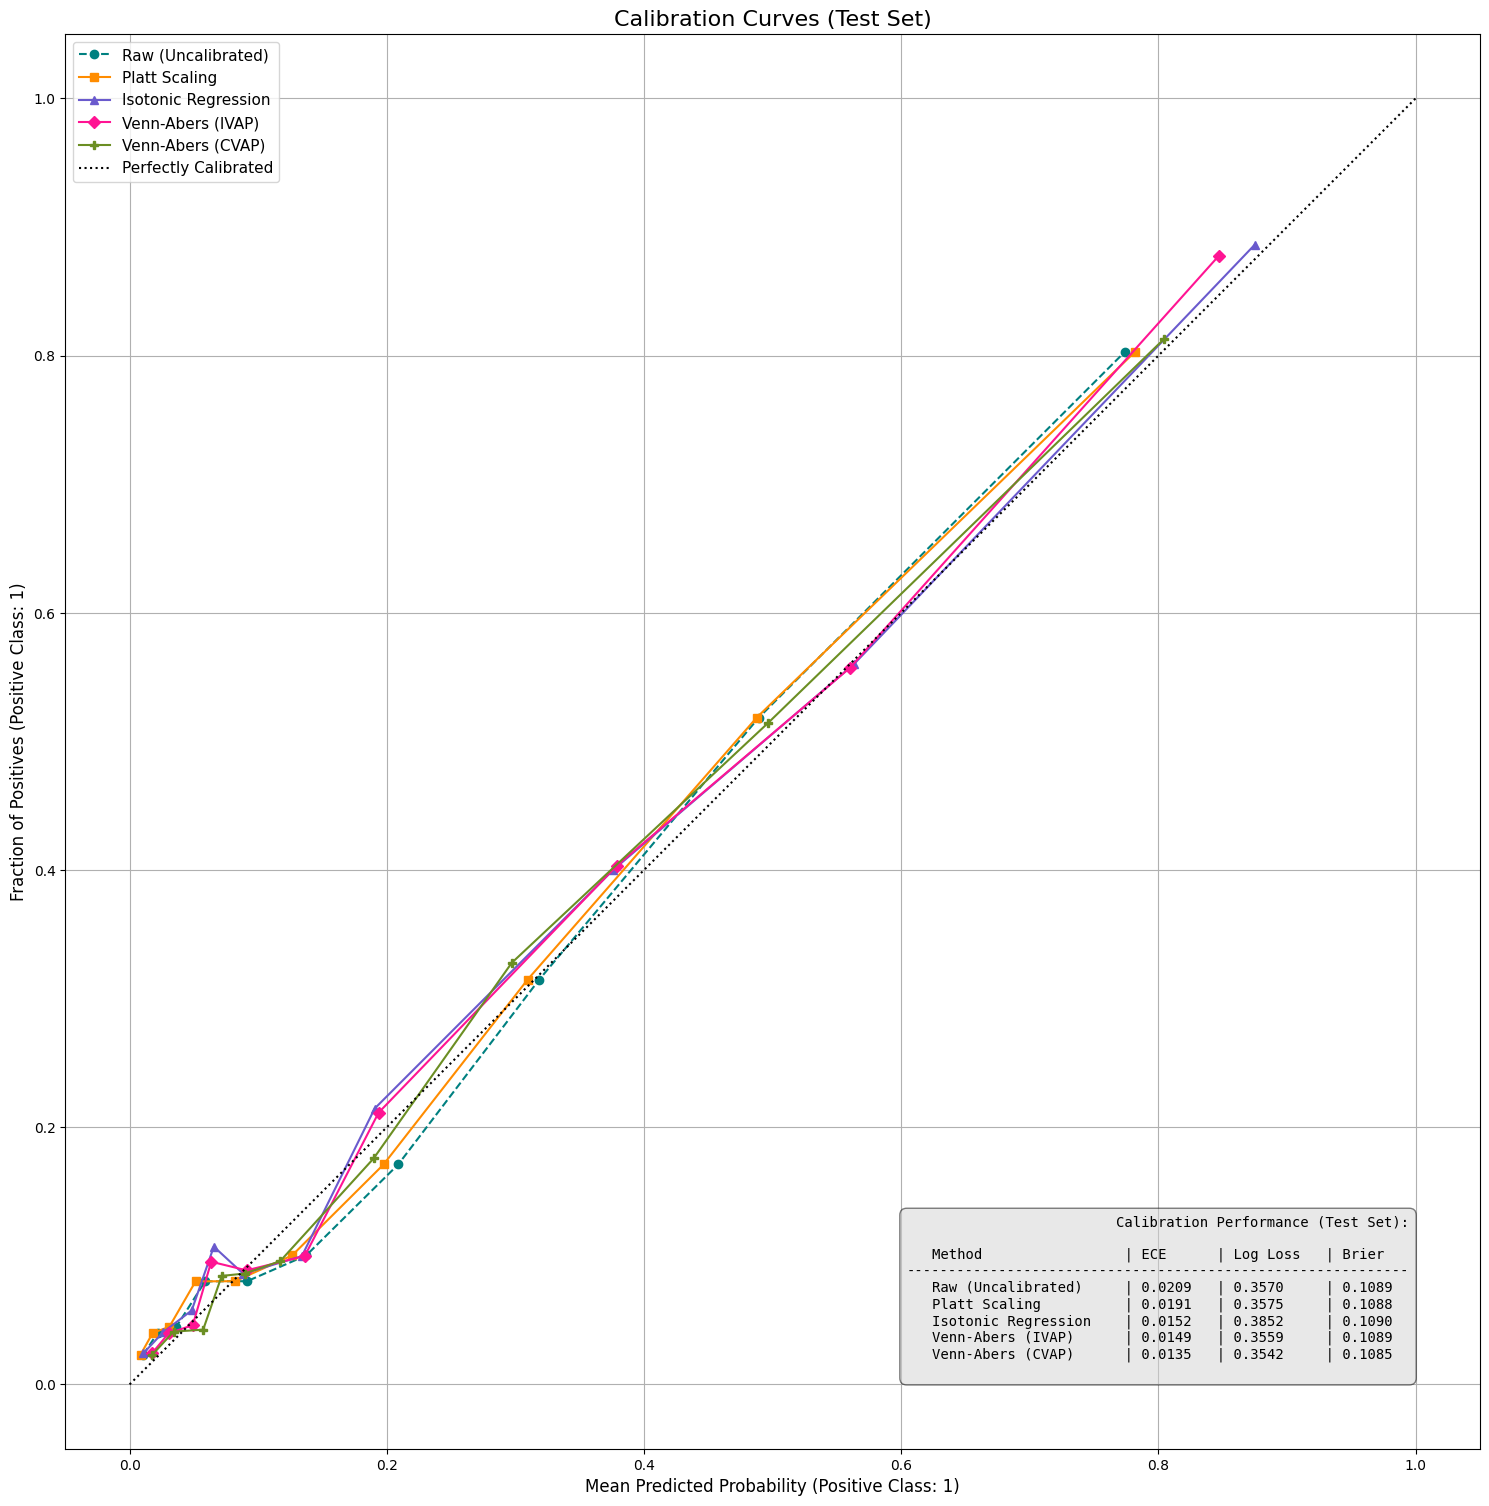

In [ ]:
fig, ax = plt.subplots(figsize=(15,20))

# --- 1. Define models, colors, and markers for clarity ---
models_to_plot = {
    'Raw (Uncalibrated)': {'color': 'teal', 'marker': 'o', 'linestyle': '--'},
    'Platt Scaling': {'color': 'darkorange', 'marker': 's', 'linestyle': '-'},
    'Isotonic Regression': {'color': 'slateblue', 'marker': '^', 'linestyle': '-'},
    'Venn-Abers (IVAP)': {'color': 'deeppink', 'marker': 'D', 'linestyle': '-'},
    'Venn-Abers (CVAP)': {'color': 'olivedrab', 'marker': 'P', 'linestyle': '-'}
}

metrics_summary = "Calibration Performance (Test Set):\n\n"
metrics_summary += f"{'Method':<22} | {'ECE':<8} | {'Log Loss':<10} | {'Brier':<8}\n"
metrics_summary += "-"*60 + "\n"

# --- 2. Loop to plot each calibration curve and collect metrics ---
for name, style in models_to_plot.items():
    y_true = prob_test['loan_status']
    y_prob = prob_test[name]
    
    # Calculate standard reliability diagram points
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_prob, n_bins=10, strategy='quantile'
    )
    
    # Plot the curve
    ax.plot(mean_predicted_value, fraction_of_positives, 
            marker=style['marker'], linestyle=style['linestyle'], label=name, color=style['color'])

    # Calculate metrics for the summary table
    ece = expected_calibration_error_manual(y_true, y_prob, num_bins=10, split_strategy='quantile') # Using quantile for ECE as well for consistency
    logloss = log_loss(y_true, y_prob)
    brier = brier_score_loss(y_true, y_prob)
    metrics_summary += f"{name:<22} | {ece:<8.4f} | {logloss:<10.4f} | {brier:<8.4f}\n"

# --- 3. Add the "Perfectly Calibrated" line and plot details ---
ax.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
ax.set_title('Calibration Curves (Test Set)', fontsize=16)
ax.set_xlabel('Mean Predicted Probability (Positive Class: 1)', fontsize=12)
ax.set_ylabel('Fraction of Positives (Positive Class: 1)', fontsize=12)
ax.grid(True)
ax.legend(loc='upper left', fontsize=11)
ax.set_aspect('equal') # Makes the plot square for better diagonal comparison

# --- 4. Add the consolidated metrics box ---
bbox_props = dict(boxstyle='round,pad=0.5', fc='lightgray', alpha=0.5)
ax.text(0.95, 0.05, metrics_summary, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right', bbox=bbox_props,
        fontname='monospace') # Monospace font for table alignment

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument

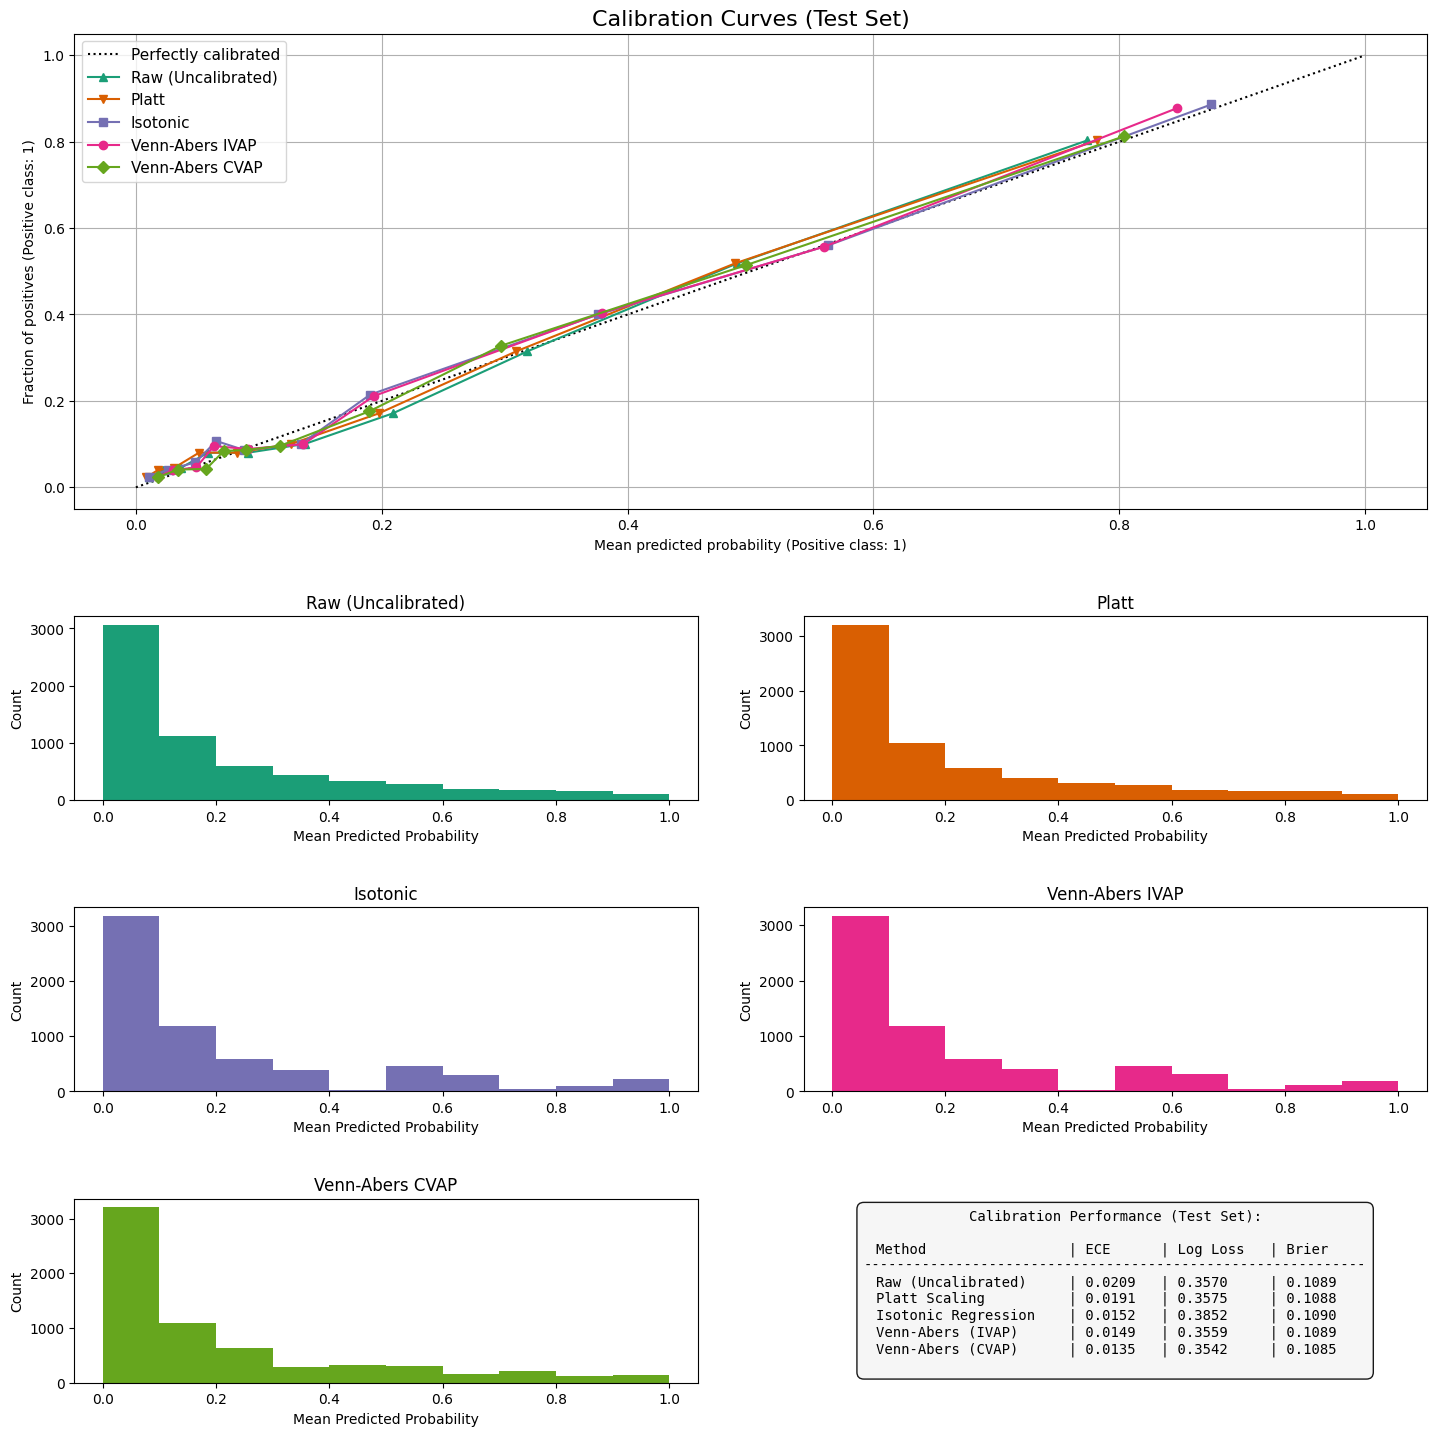

In [ ]:
# --- Setup remains the same ---
pred_list = [
    ("Raw (Uncalibrated)", "Raw (Uncalibrated)"), # Using column name for consistency
    ("Platt Scaling", "Platt"),
    ("Isotonic Regression", "Isotonic"),
    ("Venn-Abers (IVAP)", "Venn-Abers IVAP"),
    ("Venn-Abers (CVAP)", "Venn-Abers CVAP"),
]

fig = plt.figure(figsize=(15, 15)) # Made figure a bit wider
gs = GridSpec(5, 2, figure=fig)
colors = plt.get_cmap("Dark2")
markers = ["^", "v", "s", "o", "D"]

# --- NEW: Pre-calculate metrics and format them into a table string ---
metrics_summary = "Calibration Performance (Test Set):\n\n"
metrics_summary += f"{'Method':<22} | {'ECE':<8} | {'Log Loss':<10} | {'Brier':<8}\n"
metrics_summary += "-" * 60 + "\n"

for col_name, _ in pred_list:
    y_true = prob_test['loan_status']
    y_prob = prob_test[col_name]
    
    ece = expected_calibration_error_manual(y_true, y_prob, num_bins=10, split_strategy='quantile')
    logloss = log_loss(y_true, y_prob)
    brier = brier_score_loss(y_true, y_prob)
    
    # Use the shorter name for the table if you prefer
    display_name = col_name.split(' ')[0] if '(' in col_name else col_name 
    metrics_summary += f"{col_name:<22} | {ece:<8.4f} | {logloss:<10.4f} | {brier:<8.4f}\n"

# --- Calibration curve plot remains the same ---
ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (col_name, name) in enumerate(pred_list):
    display = CalibrationDisplay.from_predictions(
        prob_test['loan_status'],
        prob_test[col_name],
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
        strategy="quantile"
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Curves (Test Set)", fontsize=16)
ax_calibration_curve.legend(fontsize=11)

# --- Histograms plots remain the same ---
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4, 0)]
for i, (_, name) in enumerate(pred_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])
    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean Predicted Probability", ylabel="Count")

# --- NEW: Add the metrics table to the empty subplot space ---
ax_table = fig.add_subplot(gs[4, 1])
ax_table.axis('off') # Turn off the axis lines and labels

bbox_props = dict(boxstyle='round,pad=0.5', fc='whitesmoke', alpha=0.9)
ax_table.text(0.5, 0.5, metrics_summary, 
              ha='center', 
              va='center', 
              fontsize=10, 
              fontname='monospace', # Monospace font for table alignment
              bbox=bbox_props)

plt.tight_layout(pad=3.0) # Adjust padding to ensure titles don't overlap
plt.show()

In [224]:
# Save training probabilities
prob_tr.to_csv("probabilities_train_logistic.csv", index=False)

# Save validation probabilities
prob_val.to_csv("probabilities_validation_logistic.csv", index=False)

# Save test probabilities
prob_test.to_csv("probabilities_test_logistic.csv", index=False)
